## In this notebook, we use Care for pair wise training. We ignore the middle slices (30 to 40) and also the extreme slices (0 to 5, 65 to 70)


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped_pwregistered/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the latter half of the z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][40:65, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(25, 896, 576)


In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][5:30, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(25, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the first half of the z-slices from CM03

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][5:30, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(25, 896, 576)


In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][40:65, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(25, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(25, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(25, 896, 576)


## Visualize the images 

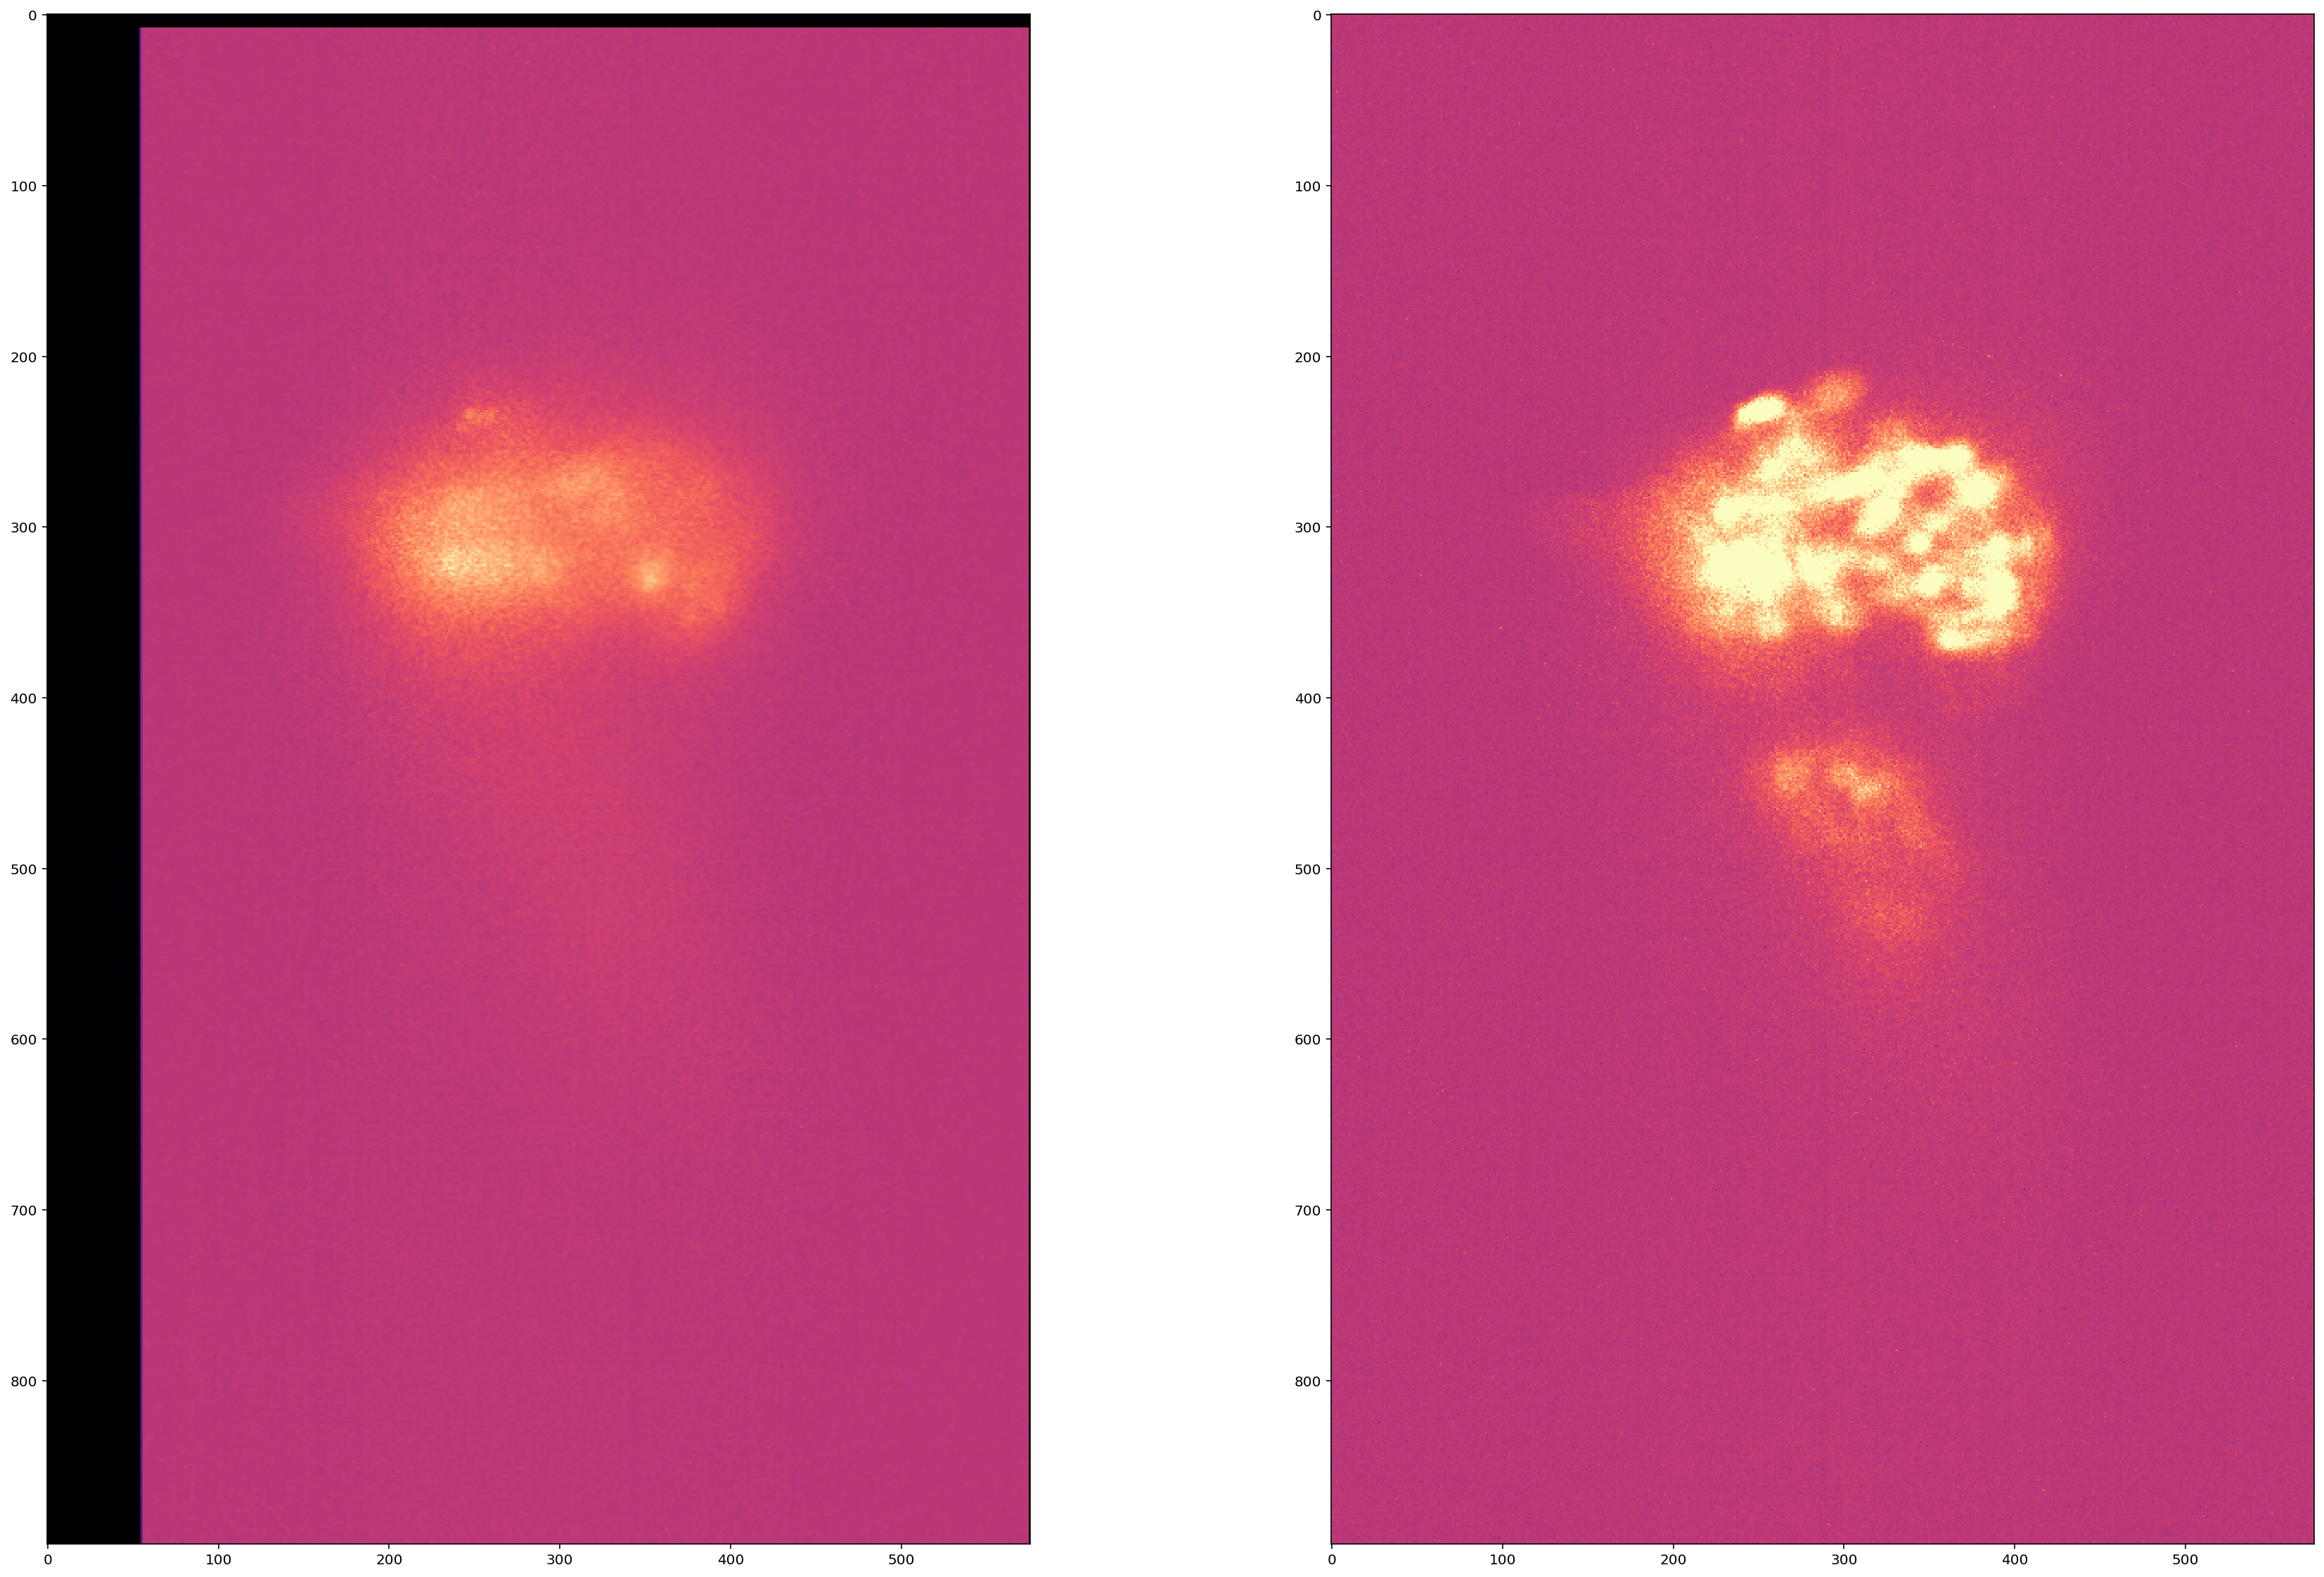

In [10]:
vmin=np.min(imgsX[4][20,...])
vmax=np.max(imgsX[4][20,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[4][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[4][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

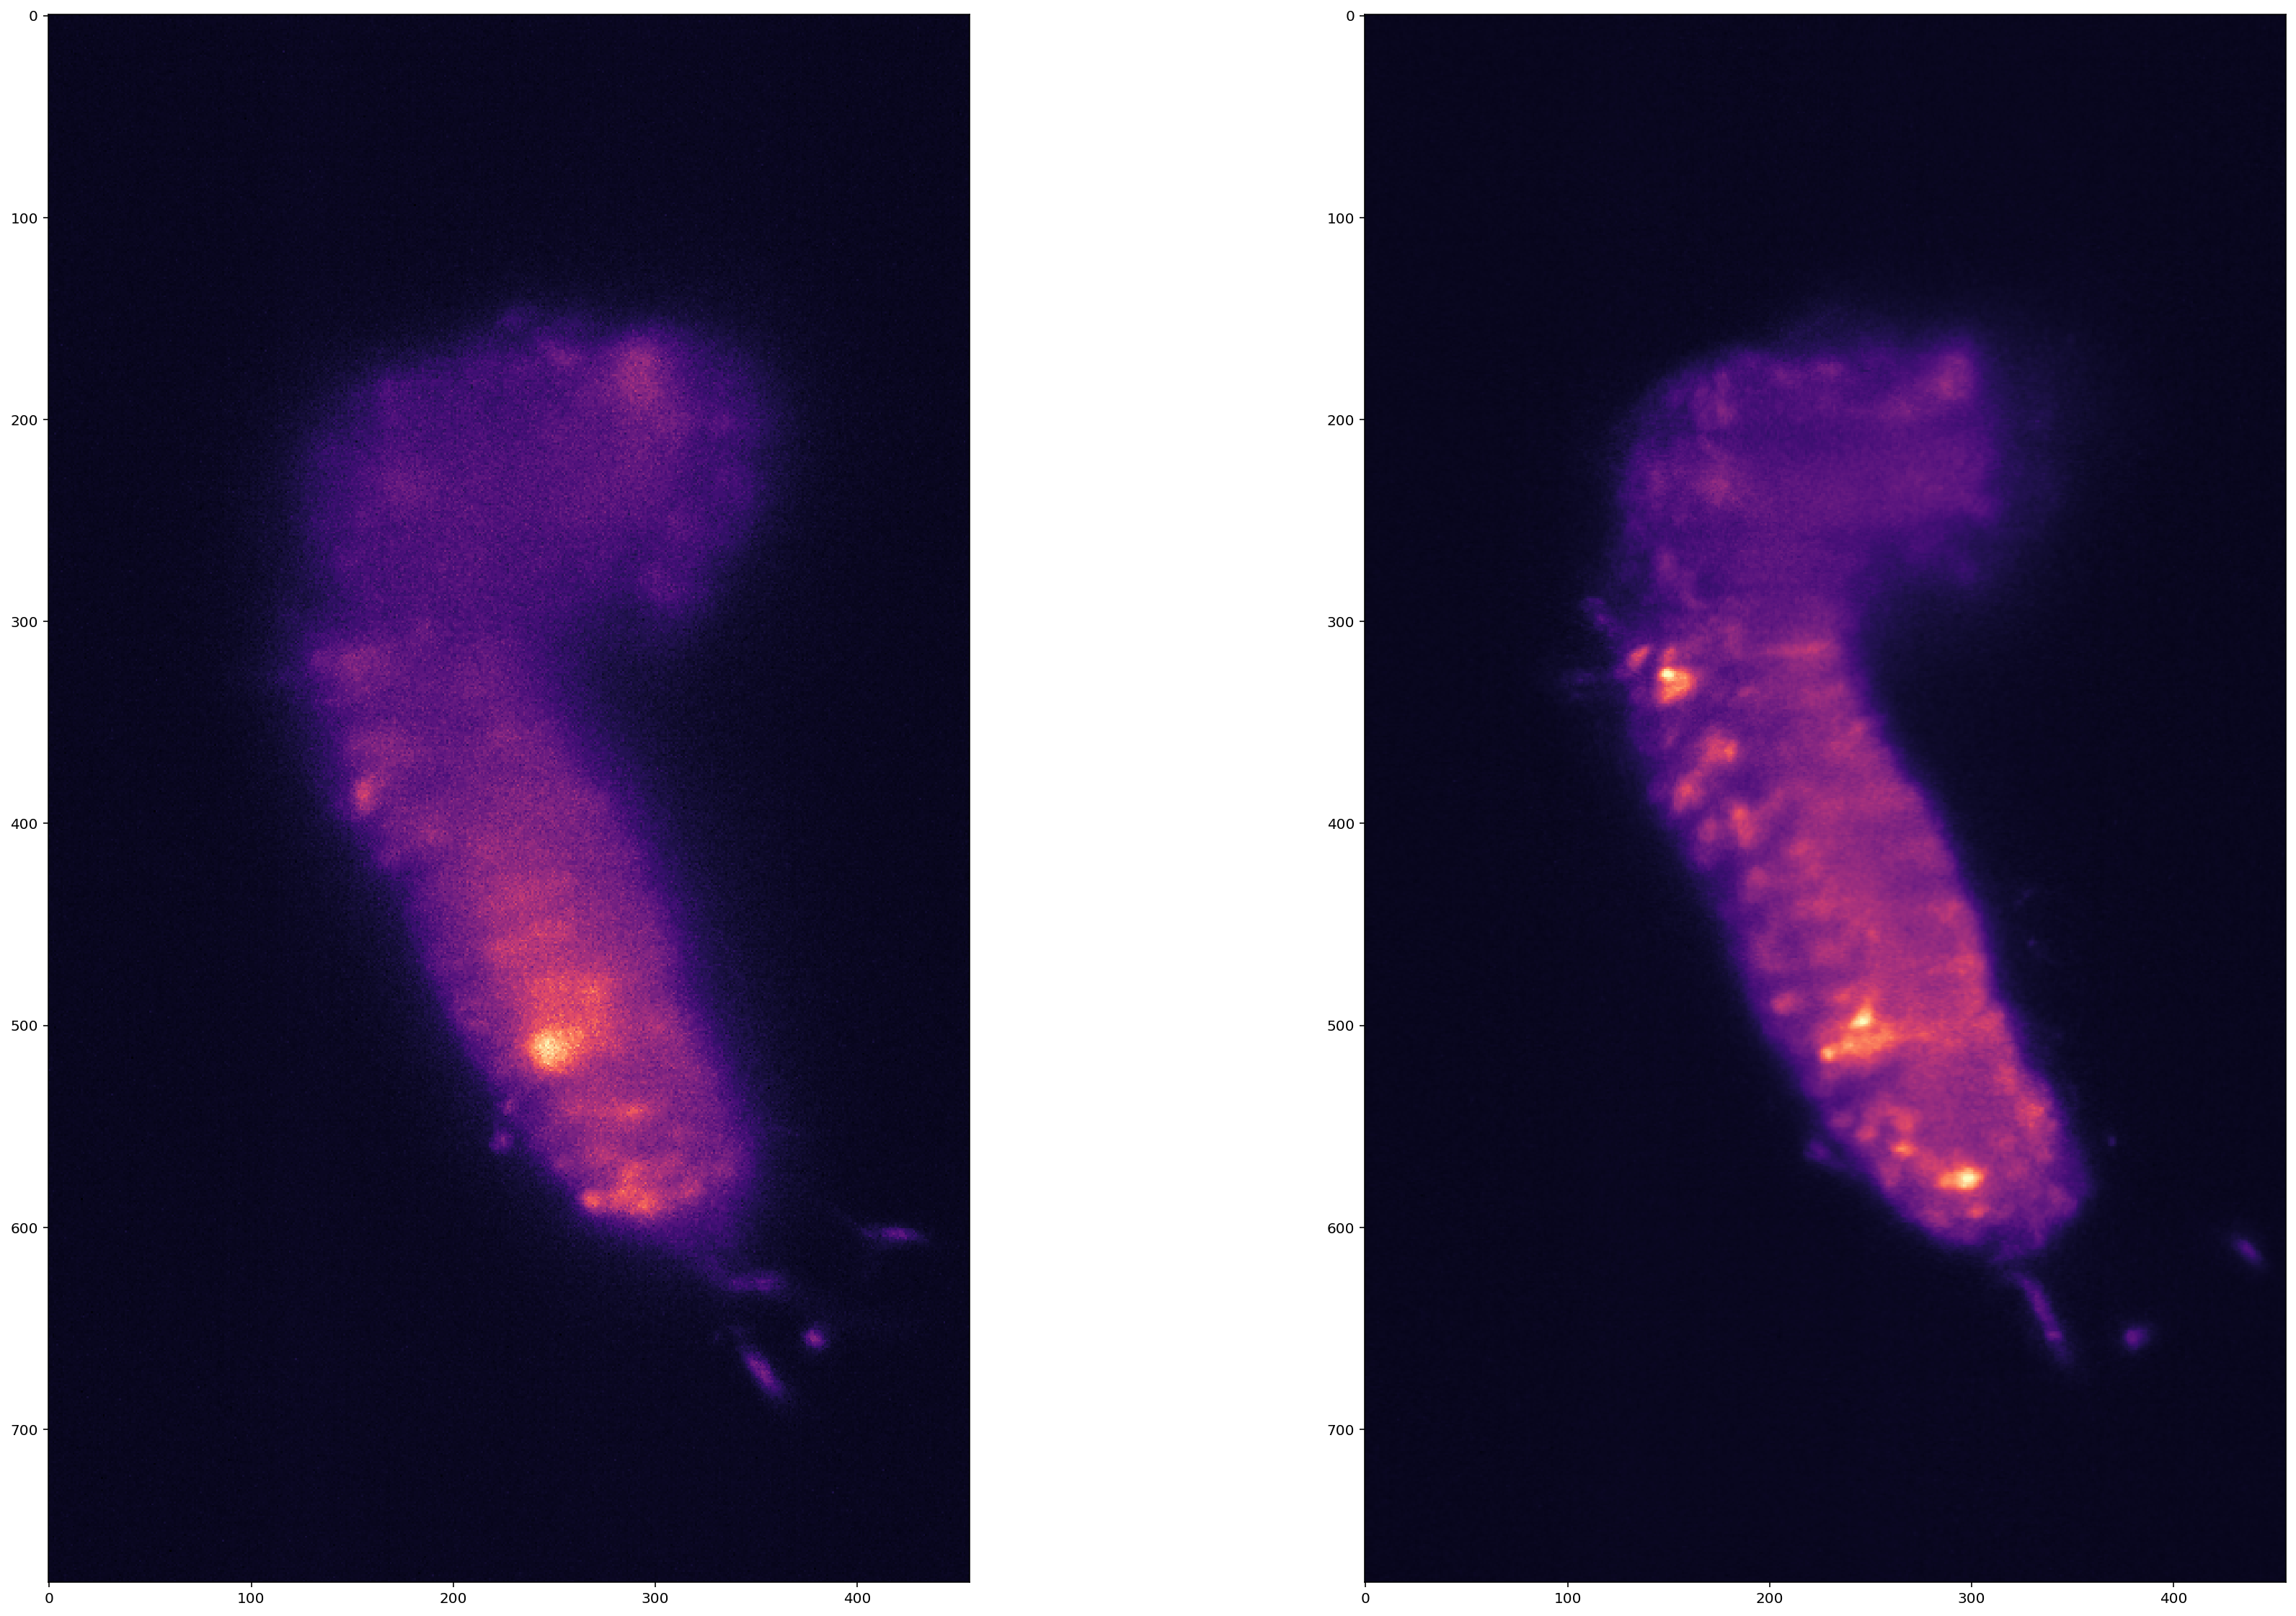

In [12]:
vmin=np.min(imgsX_chopped[15][20,...])
vmax=np.max(imgsX_chopped[15][20,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

118.11782916779707
41.85176302980436


## Create patches

In [14]:
imgsX_chopped=np.vstack(imgsX_chopped)
print(imgsX_chopped.shape)
imgsY_chopped=np.vstack(imgsY_chopped)
print(imgsY_chopped.shape)

(500, 776, 456)
(500, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=False)
print(patches.shape)

Generated patches: (16000, 96, 96, 2)
(16000, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (15000, 96, 96, 1)
Y shape:  (15000, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

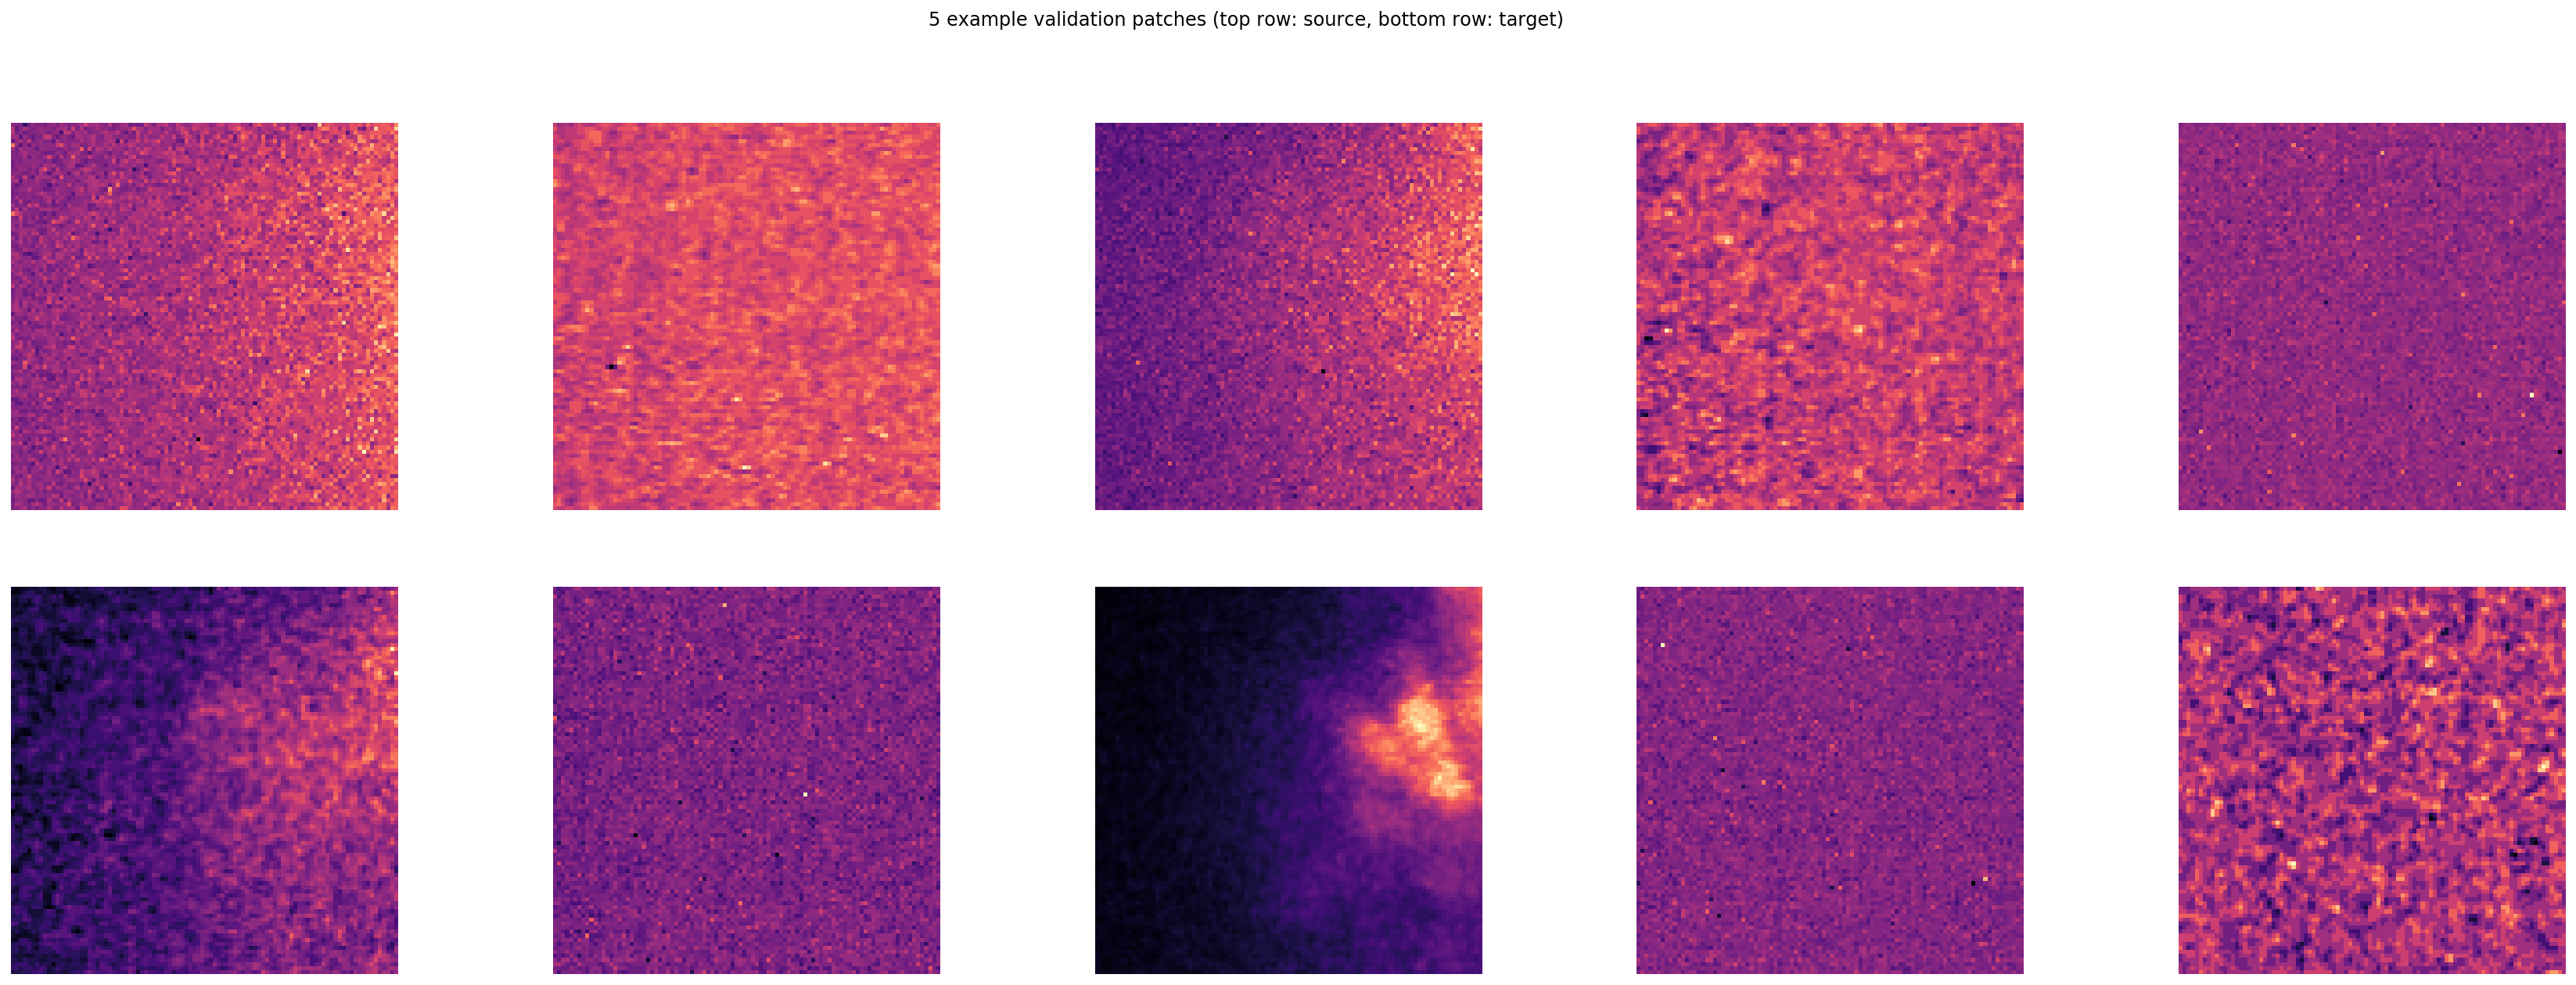

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[50:55, ...],Y_val[50:55, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=250, train_epochs=250, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=250, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=250, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 250,
 'train_steps_per_epoch': 250,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_pwregistration_float64', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/250
250/250 [==============================] - 25s 99ms/step - loss: 0.2762 - mse: 0.9916 - mae: 0.2762 - val_loss: 0.2497 - val_mse: 0.4954 - val_mae: 0.2497
Epoch 2/250
250/250 [==============================] - 22s 89ms/step - loss: 0.2379 - mse: 0.4825 - mae: 0.2379 - val_loss: 0.2578 - val_mse: 0.5447 - val_mae: 0.2578
Epoch 3/250
250/250 [==============================] - 22s 89ms/step - loss: 0.2445 - mse: 0.5024 - mae: 0.2445 - val_loss: 0.2581 - val_mse: 0.5140 - val_mae: 0.2581
Epoch 4/250
250/250 [==============================] - 22s 89ms/step - loss: 0.2211 - mse: 0.4033 - mae: 0.2211 - val_loss: 0.2585 - val_mse: 0.5261 - val_mae: 0.2585
Epoch 5/250
250/250 [==============================] - 22s 90ms/step - loss: 0.2318 - mse: 0.4531 - mae: 0.2318 - val_loss: 0.2506 - val_mse: 0.5262 - val_mae: 0.2506
Epoch 6/250
250/250 [==============================] - 22s 90ms/step - loss: 0.2323 - mse: 0.4597 - mae: 0.2323 - val_loss: 0.2301 - val_mse: 0.4492 - val_mae: 0.230

Epoch 50/250
250/250 [==============================] - 23s 91ms/step - loss: 0.1843 - mse: 0.2955 - mae: 0.1843 - val_loss: 0.1939 - val_mse: 0.3157 - val_mae: 0.1939
Epoch 51/250
250/250 [==============================] - 23s 91ms/step - loss: 0.1858 - mse: 0.2941 - mae: 0.1858 - val_loss: 0.1923 - val_mse: 0.3086 - val_mae: 0.1923
Epoch 52/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1848 - mse: 0.2912 - mae: 0.1848 - val_loss: 0.1907 - val_mse: 0.3108 - val_mae: 0.1907
Epoch 53/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1856 - mse: 0.2791 - mae: 0.1856 - val_loss: 0.1881 - val_mse: 0.2968 - val_mae: 0.1881
Epoch 54/250
250/250 [==============================] - 23s 91ms/step - loss: 0.1816 - mse: 0.2861 - mae: 0.1816 - val_loss: 0.1889 - val_mse: 0.2958 - val_mae: 0.1889
Epoch 55/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1769 - mse: 0.2579 - mae: 0.1769 - val_loss: 0.1894 - val_mse: 0.3025 - val_mae:

Epoch 98/250
250/250 [==============================] - 23s 92ms/step - loss: 0.1485 - mse: 0.1837 - mae: 0.1485 - val_loss: 0.1658 - val_mse: 0.2407 - val_mae: 0.1658
Epoch 99/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1521 - mse: 0.1964 - mae: 0.1521 - val_loss: 0.1659 - val_mse: 0.2412 - val_mae: 0.1659
Epoch 100/250
250/250 [==============================] - 23s 91ms/step - loss: 0.1507 - mse: 0.1840 - mae: 0.1507 - val_loss: 0.1643 - val_mse: 0.2336 - val_mae: 0.1643
Epoch 101/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1509 - mse: 0.2038 - mae: 0.1509 - val_loss: 0.1653 - val_mse: 0.2370 - val_mae: 0.1653
Epoch 102/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1513 - mse: 0.1873 - mae: 0.1513 - val_loss: 0.1646 - val_mse: 0.2345 - val_mae: 0.1646
Epoch 103/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1454 - mse: 0.1756 - mae: 0.1454 - val_loss: 0.1653 - val_mse: 0.2373 - val_

250/250 [==============================] - 22s 90ms/step - loss: 0.1347 - mse: 0.1446 - mae: 0.1347 - val_loss: 0.1628 - val_mse: 0.2312 - val_mae: 0.1628
Epoch 147/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1379 - mse: 0.1590 - mae: 0.1379 - val_loss: 0.1632 - val_mse: 0.2285 - val_mae: 0.1632
Epoch 148/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1374 - mse: 0.1529 - mae: 0.1374 - val_loss: 0.1626 - val_mse: 0.2286 - val_mae: 0.1626
Epoch 149/250
250/250 [==============================] - 23s 91ms/step - loss: 0.1453 - mse: 0.1775 - mae: 0.1453 - val_loss: 0.1626 - val_mse: 0.2305 - val_mae: 0.1626

Epoch 00149: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 150/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1426 - mse: 0.1688 - mae: 0.1426 - val_loss: 0.1626 - val_mse: 0.2295 - val_mae: 0.1626
Epoch 151/250
250/250 [==============================] - 23s 92ms/step - loss: 0.1399 - 

250/250 [==============================] - 22s 90ms/step - loss: 0.1342 - mse: 0.1488 - mae: 0.1342 - val_loss: 0.1621 - val_mse: 0.2290 - val_mae: 0.1621
Epoch 194/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1415 - mse: 0.1635 - mae: 0.1415 - val_loss: 0.1621 - val_mse: 0.2283 - val_mae: 0.1621
Epoch 195/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1349 - mse: 0.1594 - mae: 0.1349 - val_loss: 0.1621 - val_mse: 0.2295 - val_mae: 0.1621
Epoch 196/250
250/250 [==============================] - 23s 92ms/step - loss: 0.1366 - mse: 0.1610 - mae: 0.1366 - val_loss: 0.1622 - val_mse: 0.2291 - val_mae: 0.1622
Epoch 197/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1396 - mse: 0.1580 - mae: 0.1396 - val_loss: 0.1621 - val_mse: 0.2283 - val_mae: 0.1621
Epoch 198/250
250/250 [==============================] - 23s 92ms/step - loss: 0.1394 - mse: 0.1677 - mae: 0.1394 - val_loss: 0.1621 - val_mse: 0.2281 - val_mae: 0.1621


Epoch 240/250
250/250 [==============================] - 23s 92ms/step - loss: 0.1409 - mse: 0.1735 - mae: 0.1409 - val_loss: 0.1621 - val_mse: 0.2286 - val_mae: 0.1621
Epoch 241/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1403 - mse: 0.1571 - mae: 0.1403 - val_loss: 0.1621 - val_mse: 0.2286 - val_mae: 0.1621
Epoch 242/250
250/250 [==============================] - 22s 90ms/step - loss: 0.1361 - mse: 0.1540 - mae: 0.1361 - val_loss: 0.1621 - val_mse: 0.2287 - val_mae: 0.1621

Epoch 00242: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 243/250
250/250 [==============================] - 23s 90ms/step - loss: 0.1331 - mse: 0.1523 - mae: 0.1331 - val_loss: 0.1621 - val_mse: 0.2287 - val_mae: 0.1621
Epoch 244/250
250/250 [==============================] - 22s 89ms/step - loss: 0.1393 - mse: 0.1575 - mae: 0.1393 - val_loss: 0.1621 - val_mse: 0.2287 - val_mae: 0.1621
Epoch 245/250
250/250 [==============================] - 23s 93ms/step - l

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


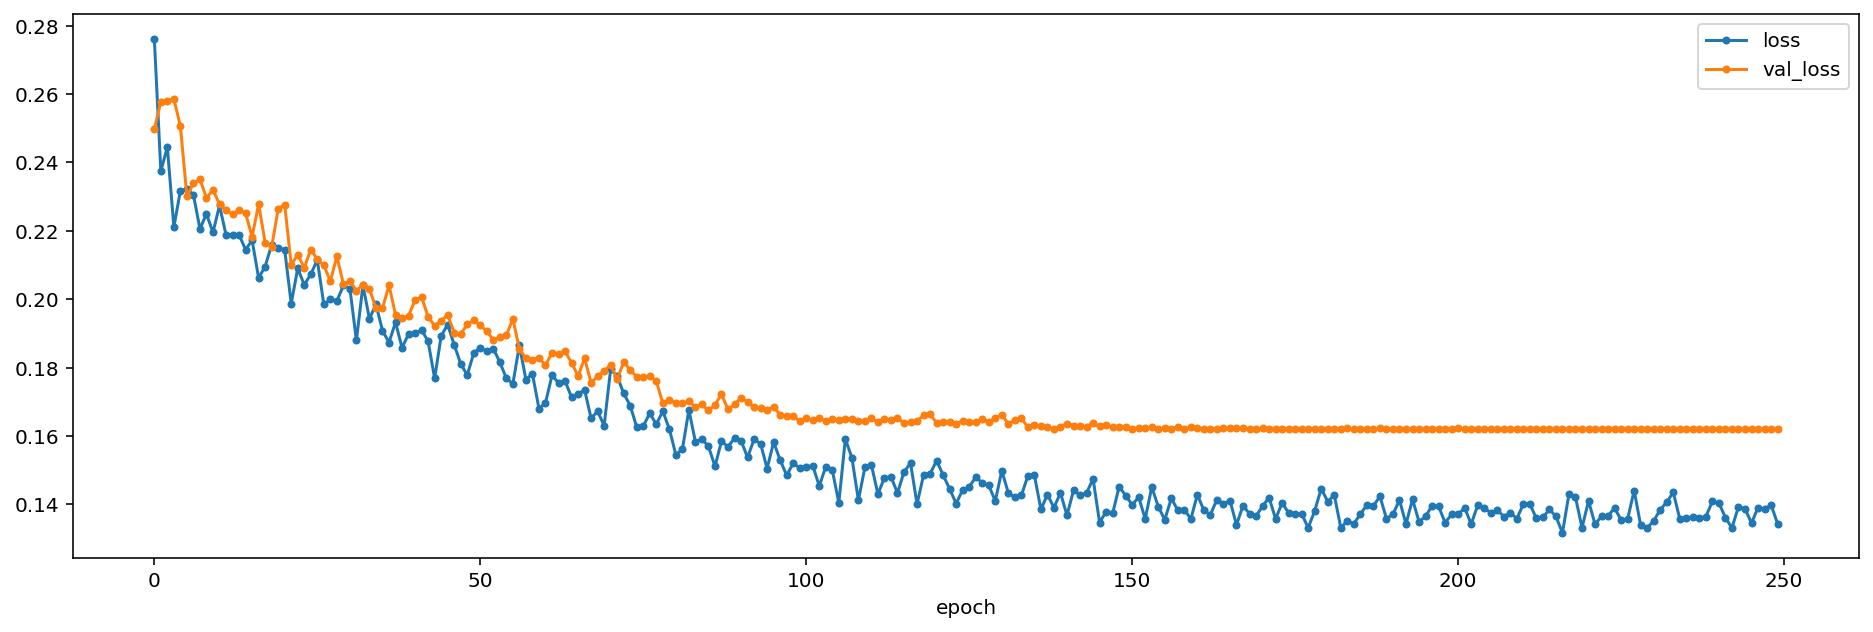

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);